In [1]:
%load_ext autoreload
%autoreload 2

# Citation Network Analysis — Logit Graph vs Baseline Models

Fit the Logit Graph model to the **full** Arxiv High Energy Physics Theory
citation network (`cit-HepTh`) and compare with classical random graph
families (ER, WS, BA).

### Performance strategy

All spectral density computations use the **Kernel Polynomial Method (KPM)**
operating on the *sparse* normalised Laplacian. This avoids the O(n³) full
eigendecomposition, bringing each spectral density estimate from **minutes
to seconds** on a 27k-node graph.

| Step | Exact eigvalsh | KPM (this notebook) |
|------|---------------|---------------------|
| Spectral density | O(n³) ≈ 2–7 min | O(K·R·nnz) ≈ 3–8 s |
| Memory per call  | ~5.7 GB dense  | ~15 MB sparse |
| Parameter estimation | needs dense adj | NetworkX only |

In [2]:
import sys, os, gc, time, math, pickle, warnings
sys.path.insert(0, os.path.abspath('../..'))

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from scipy.stats import entropy
from scipy.spatial.distance import euclidean, cityblock
from scipy.special import expit
from tqdm.auto import tqdm
import statsmodels.api as sm

from logit_graph.graph import GraphModel

sns.set_style('whitegrid')
plt.rcParams.update({'figure.dpi': 120, 'font.size': 11})

DATA_DIR = os.path.abspath('../../data/citation_networks')
OUTPUT_DIR = 'runs/citation'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print('Data dir:', DATA_DIR)
print('Output dir:', OUTPUT_DIR)

Data dir: /Users/maruanottoni/home/master/research/logit-graph/data/citation_networks
Output dir: runs/citation


---
## 1. Load & explore the full citation network

In [3]:
citation_path = os.path.join(DATA_DIR, 'cit-HepTh.txt')
G_directed = nx.read_edgelist(citation_path, comments='#', delimiter='\t',
                               create_using=nx.DiGraph(), nodetype=int)
G_full = G_directed.to_undirected()
G_full.remove_edges_from(nx.selfloop_edges(G_full))

print(f'Full undirected graph:')
print(f'  Nodes: {G_full.number_of_nodes():,}')
print(f'  Edges: {G_full.number_of_edges():,}')
print(f'  Density: {nx.density(G_full):.6f}')
print(f'  Components: {nx.number_connected_components(G_full)}')

# Largest connected component
gcc_nodes = max(nx.connected_components(G_full), key=len)
G_gcc = G_full.subgraph(gcc_nodes).copy()
G_gcc = nx.convert_node_labels_to_integers(G_gcc)
n = G_gcc.number_of_nodes()
m = G_gcc.number_of_edges()

print(f'\nLargest connected component (target graph):')
print(f'  Nodes: {n:,}')
print(f'  Edges: {m:,}')
print(f'  Density: {nx.density(G_gcc):.6f}')

del G_directed, G_full
gc.collect()
print('\nTarget graph: G_gcc')

Full undirected graph:
  Nodes: 27,770
  Edges: 352,285
  Density: 0.000914
  Components: 143

Largest connected component (target graph):
  Nodes: 27,400
  Edges: 352,021
  Density: 0.000938

Target graph: G_gcc


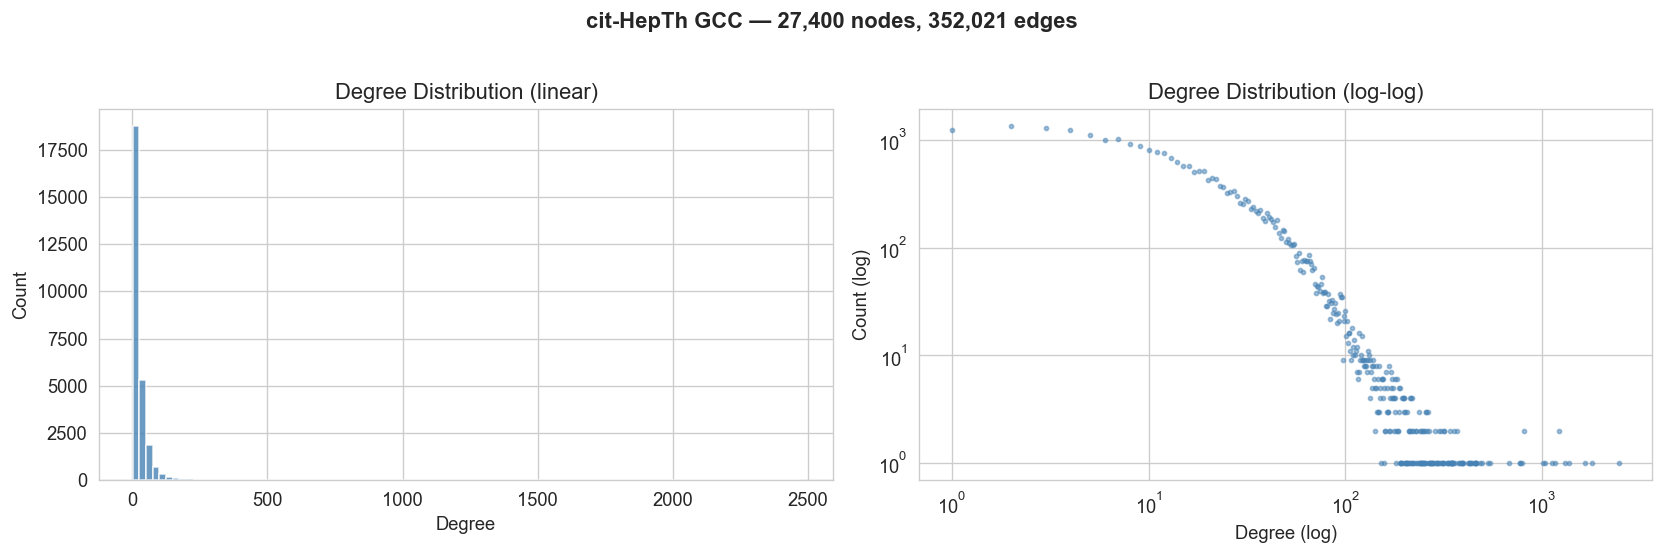

Degree stats: mean=25.7, median=15, max=2468, min=1


In [4]:
# Degree distribution
degrees = np.array([d for _, d in G_gcc.degree()])

fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))

axes[0].hist(degrees, bins=100, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Count')
axes[0].set_title('Degree Distribution (linear)')

deg_counts = pd.Series(degrees).value_counts().sort_index()
axes[1].scatter(deg_counts.index, deg_counts.values, s=6, alpha=0.5, color='steelblue')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Degree (log)')
axes[1].set_ylabel('Count (log)')
axes[1].set_title('Degree Distribution (log-log)')

fig.suptitle(f'cit-HepTh GCC — {n:,} nodes, {m:,} edges', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f'Degree stats: mean={degrees.mean():.1f}, median={np.median(degrees):.0f}, '
      f'max={degrees.max()}, min={degrees.min()}')

---
## 2. Efficient spectral helpers — KPM + sparse Laplacian

The **Kernel Polynomial Method** estimates the spectral density (density of
states) of the normalised Laplacian using only **sparse matrix–vector
products**. Cost: `O(n_random × n_moments × nnz)`.

For our graph (nnz ≈ 730k) with 50 random probes and 150 Chebyshev moments,
each call takes **3–8 seconds** vs 2–7 minutes for full eigvalsh.

In [5]:
def sparse_normalized_laplacian(G_or_adj):
    """Build the sparse normalised Laplacian  L = I - D^{-1/2} A D^{-1/2}.

    Accepts a NetworkX graph (preferred — stays sparse throughout) or a
    dense numpy adjacency matrix.
    """
    if isinstance(G_or_adj, nx.Graph):
        A = nx.adjacency_matrix(G_or_adj).astype(np.float64)
    elif isinstance(G_or_adj, np.ndarray):
        A = sp.csr_matrix(G_or_adj)
    else:
        A = sp.csr_matrix(G_or_adj)

    n = A.shape[0]
    deg = np.asarray(A.sum(axis=1)).ravel()
    d_inv_sqrt = np.zeros(n)
    mask = deg > 0
    d_inv_sqrt[mask] = 1.0 / np.sqrt(deg[mask])

    D_inv_sqrt = sp.diags(d_inv_sqrt)
    L = sp.eye(n, format='csr') - D_inv_sqrt @ A @ D_inv_sqrt
    return L.tocsr()


def kpm_dos(L_sparse, n_moments=150, n_random=50, n_bins=50, seed=42):
    """Kernel Polynomial Method — spectral density estimation.

    Estimates the density of states of a matrix whose eigenvalues lie in
    [0, 2] (normalised Laplacian).  Returns a histogram vector that is
    directly compatible with GIC's ``compute_spectral_density``.

    Complexity: O(n_random × n_moments × nnz(L))  (seconds for sparse graphs).
    """
    rng = np.random.default_rng(seed)
    n = L_sparse.shape[0]
    K = n_moments

    # Rescale from [0, 2] to [-1, 1]:  M = L - I
    M = (L_sparse - sp.eye(n, format='csr')).tocsr()

    # Jackson damping kernel (suppresses Gibbs oscillations)
    k = np.arange(K, dtype=np.float64)
    Kp1 = K + 1.0
    jackson = (
        (Kp1 - k) * np.cos(np.pi * k / Kp1)
        + np.sin(np.pi * k / Kp1) / np.tan(np.pi / Kp1)
    ) / Kp1

    # ── Stochastic Chebyshev moment estimation ──
    mu = np.zeros(K)
    for _ in range(n_random):
        v = rng.choice([-1.0, 1.0], size=n)       # Rademacher probe
        t0 = v.copy()                              # T_0(M) v = v
        t1 = M.dot(v)                              # T_1(M) v = M v
        mu[0] += v.dot(t0)
        if K > 1:
            mu[1] += v.dot(t1)
        for j in range(2, K):
            t2 = 2.0 * M.dot(t1) - t0
            mu[j] += v.dot(t2)
            t0, t1 = t1, t2

    mu /= (n_random * n)

    # ── Reconstruct density at bin centres ──
    bin_edges = np.linspace(0, 2, n_bins + 1)
    centres = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    x = np.clip(centres - 1.0, -1 + 1e-10, 1 - 1e-10)   # map to (-1, 1)

    acos_x = np.arccos(x)
    rho = jackson[0] * mu[0] * np.ones_like(x)
    for j in range(1, K):
        rho += 2.0 * jackson[j] * mu[j] * np.cos(j * acos_x)
    rho /= (np.pi * np.sqrt(1.0 - x * x))

    # Normalise (integral over [0, 2] ≈ 1, matching density=True histogram)
    rho = np.maximum(rho, 0.0)
    bin_w = bin_edges[1] - bin_edges[0]
    total = rho.sum() * bin_w
    if total > 0:
        rho /= total
    return rho


def compute_gic(real_density, model_density, dist='KL'):
    """GIC from two pre-computed spectral density histograms."""
    eps = 1e-10
    if dist == 'KL':
        return float(entropy(real_density + eps, model_density + eps))
    elif dist == 'L1':
        return float(cityblock(real_density, model_density))
    elif dist == 'L2':
        return float(euclidean(real_density, model_density))
    raise ValueError(f'Unknown dist: {dist}')


print('Helpers defined.')

Helpers defined.


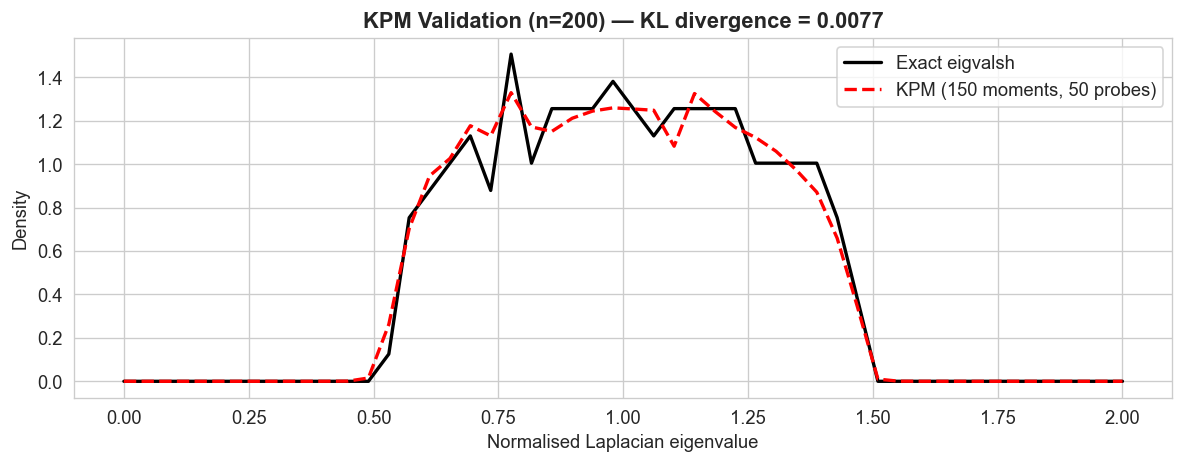

Exact vs KPM — KL divergence: 0.007723
L2 distance:   0.530690


In [6]:
# ── Validate KPM vs exact eigvalsh on a small graph ──
G_val = nx.erdos_renyi_graph(200, 0.08, seed=7)
G_val = G_val.subgraph(max(nx.connected_components(G_val), key=len)).copy()
G_val = nx.convert_node_labels_to_integers(G_val)

# Exact
adj_val = nx.to_numpy_array(G_val)
n_val = adj_val.shape[0]
D = np.diag(adj_val.sum(1))
d_isq = np.zeros(n_val)
mask = adj_val.sum(1) > 0
d_isq[mask] = 1.0 / np.sqrt(adj_val.sum(1)[mask])
L_exact = np.eye(n_val) - (adj_val * d_isq[:, None] * d_isq[None, :])
eigs_exact = np.linalg.eigvalsh(L_exact)
hist_exact, _ = np.histogram(eigs_exact, bins=50, range=(0, 2), density=True)

# KPM
L_sp = sparse_normalized_laplacian(G_val)
hist_kpm = kpm_dos(L_sp, n_moments=150, n_random=50)

gic_self = compute_gic(hist_exact, hist_kpm)

fig, ax = plt.subplots(figsize=(10, 4))
bins = np.linspace(0, 2, 50)
ax.plot(bins, hist_exact, 'k-', lw=2, label='Exact eigvalsh')
ax.plot(bins, hist_kpm, 'r--', lw=2, label='KPM (150 moments, 50 probes)')
ax.set_xlabel('Normalised Laplacian eigenvalue')
ax.set_ylabel('Density')
ax.set_title(f'KPM Validation (n={n_val}) — KL divergence = {gic_self:.4f}', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

print(f'Exact vs KPM — KL divergence: {gic_self:.6f}')
print(f'L2 distance:   {np.linalg.norm(hist_exact - hist_kpm):.6f}')

---
## 3. Cache the original graph's spectral density (KPM)

In [7]:
# Build sparse normalised Laplacian directly from NetworkX (no dense matrix!)
t0 = time.perf_counter()
L_real_sparse = sparse_normalized_laplacian(G_gcc)
t_build = time.perf_counter() - t0
print(f'Sparse L_norm built in {t_build:.2f}s  '
      f'(nnz={L_real_sparse.nnz:,}, '
      f'memory≈{L_real_sparse.data.nbytes / 1e6:.1f} MB)')

# KPM spectral density
t0 = time.perf_counter()
real_density = kpm_dos(L_real_sparse, n_moments=200, n_random=60)
t_kpm = time.perf_counter() - t0
print(f'KPM spectral density computed in {t_kpm:.2f}s')
print(f'\nOriginal spectral density cached (no dense matrix created).')

Sparse L_norm built in 0.54s  (nnz=731,442, memory≈5.9 MB)
KPM spectral density computed in 7.77s

Original spectral density cached (no dense matrix created).


---
## 4. Estimate Logit Graph parameters (no dense matrix)

Parameter estimation uses **sampled** logistic regression — we sample edges
and non-edges from the NetworkX graph and compute degree features from the
sparse representation. The 5.7 GB dense adjacency is **never created**.

In [9]:
d = 0  # d=0 recommended for large graphs

t0 = time.perf_counter()

# Degree features from NetworkX (sparse, O(m))
degree_dict = dict(G_gcc.degree())
sum_degrees = np.array([degree_dict.get(v, 0) for v in range(n)], dtype=np.float64)

# Sample edges
rng = np.random.default_rng(42)
edges_all = list(G_gcc.edges())
n_sample = min(50_000, len(edges_all))
edge_idx = rng.choice(len(edges_all), size=n_sample, replace=False)
edge_sample = [edges_all[i] for i in edge_idx]

# Sample non-edges (rejection sampling)
edge_set = set((min(i, j), max(i, j)) for i, j in edges_all)
non_edge_sample = []
while len(non_edge_sample) < n_sample:
    i = int(rng.integers(0, n))
    j = int(rng.integers(0, n))
    if i == j:
        continue
    pair = (min(i, j), max(i, j))
    if pair not in edge_set:
        non_edge_sample.append((i, j))

# Build features & labels
pairs = edge_sample + non_edge_sample
labels = [1] * len(edge_sample) + [0] * len(non_edge_sample)
feats = np.array([sum_degrees[i] + sum_degrees[j] for i, j in pairs]).reshape(-1, 1)
features = sm.add_constant(feats)

# Fit logistic regression
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    logit_model = sm.Logit(labels, features)
    result = logit_model.fit_regularized(method='l1', alpha=0, disp=False)

sigma = float(result.params[0])
beta  = float(result.params[1])
t_est = time.perf_counter() - t0

print(f'Estimation time: {t_est:.1f}s')
print(f'  sigma = {sigma:.4f}')
print(f'  beta  = {beta:.4f}')
print(f'  d     = {d}')
print(f'  samples: {n_sample:,} edges + {n_sample:,} non-edges')

Estimation time: 0.4s
  sigma = -1.5153
  beta  = 0.0182
  d     = 0
  samples: 50,000 edges + 50,000 non-edges


---
## 5. Fit the Logit Graph on the full graph

Memory-efficient custom loop:
- Only `gm.graph` (current) and `best_graph` are kept in RAM.
- Convergence uses the L2 distance between **KPM spectral densities**,
  consistent with the GIC framework.

In [83]:
# ── Tunable parameters ──
MAX_ITERATIONS = 200_000
CHECK_INTERVAL = 5_000
WARM_UP        = 10_000
PATIENCE       = 800
ER_SEED_P      = 1.25 * (nx.density(G_gcc) / 2) 

print(f'max_iterations = {MAX_ITERATIONS:,}')
print(f'check_interval = {CHECK_INTERVAL:,}')
print(f'warm_up        = {WARM_UP:,}')
print(f'patience       = {PATIENCE}')
print(f'er_seed_p      = {ER_SEED_P:.6f}')
print(f'sigma          = {sigma:.4f}')
print(f'beta           = {beta:.4f}')
print(f'Expected spectrum checks: ~{MAX_ITERATIONS // CHECK_INTERVAL}')
print(f'Expected time per check: ~{t_kpm:.0f}s  '
      f'(total ≈ {MAX_ITERATIONS // CHECK_INTERVAL * (t_kpm + 3):.0f}s)')

max_iterations = 200,000
check_interval = 5,000
warm_up        = 10,000
patience       = 800
er_seed_p      = 0.000586
sigma          = -1.5153
beta           = 0.0182
Expected spectrum checks: ~40
Expected time per check: ~8s  (total ≈ 431s)


In [84]:
# ── Build model & run fitting loop ──
from tqdm import tqdm
gm = GraphModel(n=n, d=d, sigma=sigma, beta=beta, er_p=ER_SEED_P)
print(f'Initial graph: {gm._edge_count:,} edges  '
      f'(dense adj = {gm.graph.nbytes / 1e9:.2f} GB)')

# 50_000 iter good results

best_graph = gm.graph.copy()
best_diff  = float('inf')
best_iter  = 0
no_improve = 0

hist_diffs  = []
edge_counts = []
check_iters = []

pbar = tqdm(total=MAX_ITERATIONS, desc='Fitting LG (full graph)')
t_start = time.perf_counter()

for i in tqdm(range(MAX_ITERATIONS), desc='Fitting LG (full graph)'):
    gm.add_remove_edge()

    if i > 0 and i % CHECK_INTERVAL == 0:
        t_c = time.perf_counter()

        # KPM spectral density of current graph (sparse conversion + KPM)
        L_cur = sparse_normalized_laplacian(gm.graph)
        cur_density = kpm_dos(L_cur, n_moments=150, n_random=40)
        diff = float(np.linalg.norm(cur_density - real_density))

        hist_diffs.append(diff)
        edge_counts.append(gm._edge_count)
        check_iters.append(i)
        dt = time.perf_counter() - t_c

        if diff < best_diff:
            best_diff = diff
            best_graph = gm.graph.copy()
            best_iter = i
            no_improve = 0
        elif i >= WARM_UP:
            no_improve += 1

        pbar.set_postfix({
            'L2': f'{diff:.4f}',
            'best': f'{best_diff:.4f}',
            'edges': f'{gm._edge_count:,}',
            'pat': f'{no_improve}/{PATIENCE}',
            'dt': f'{dt:.1f}s',
        })

        if i >= WARM_UP and no_improve >= PATIENCE:
            pbar.write(f'Converged at iter {i:,} (no improvement for {PATIENCE} checks)')
            break

    pbar.update(1)

pbar.close()
t_total = time.perf_counter() - t_start

gm.graph = best_graph
gm._init_cache()

print(f'\nFitting complete in {t_total:.1f}s ({t_total/60:.1f} min)')
print(f'  Best iteration:  {best_iter:,}')
print(f'  Best L2 diff:    {best_diff:.4f}')
print(f'  Edges (best):    {gm._edge_count:,}  (real: {m:,})')

Initial graph: 220,375 edges  (dense adj = 6.01 GB)


Fitting LG (full graph): 100%|██████████| 200000/200000 [07:45<00:00, 429.31it/s, L2=2.2042, best=2.2042, edges=278,611, pat=0/800, dt=9.2s]



Fitting complete in 465.9s (7.8 min)
  Best iteration:  195,000
  Best L2 diff:    2.2042
  Edges (best):    278,611  (real: 352,021)


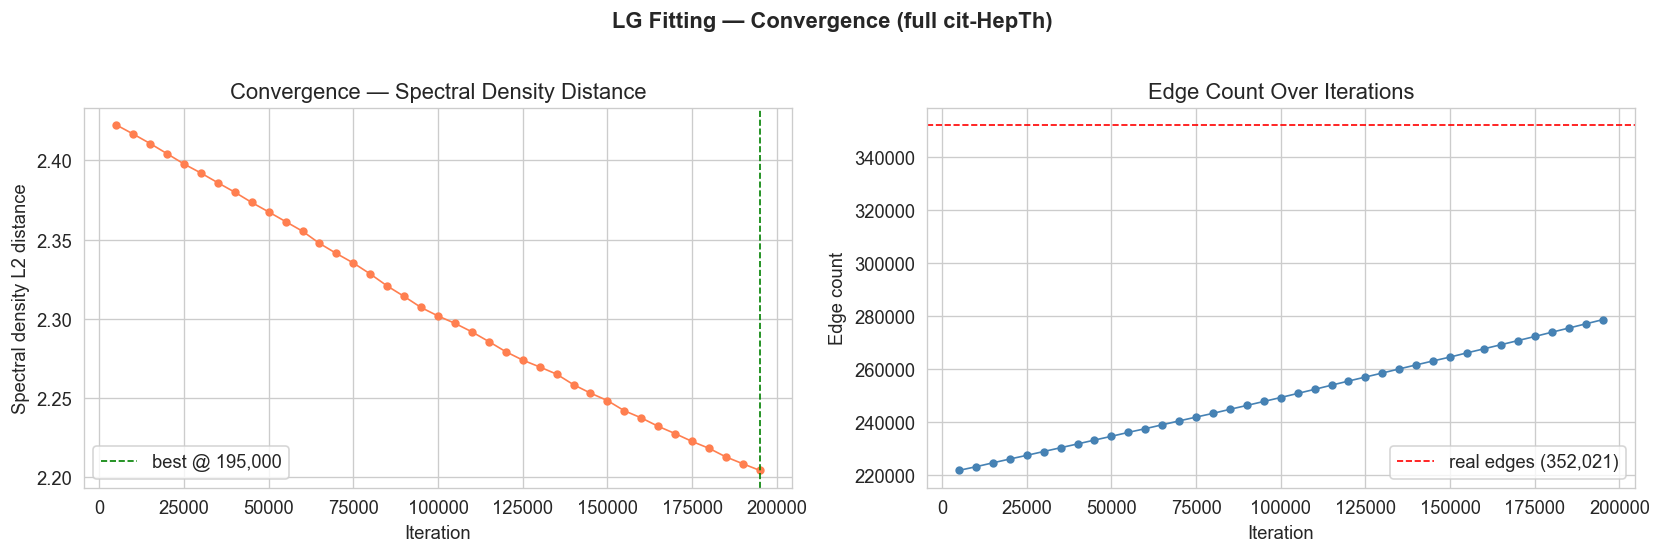

In [85]:
# Convergence plot
fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))

axes[0].plot(check_iters, hist_diffs, 'o-', ms=4, color='coral', lw=1)
axes[0].axvline(best_iter, color='green', ls='--', lw=1,
                label=f'best @ {best_iter:,}')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Spectral density L2 distance')
axes[0].set_title('Convergence — Spectral Density Distance')
axes[0].legend()

axes[1].plot(check_iters, edge_counts, 'o-', ms=4, color='steelblue', lw=1)
axes[1].axhline(m, color='red', ls='--', lw=1, label=f'real edges ({m:,})')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Edge count')
axes[1].set_title('Edge Count Over Iterations')
axes[1].legend()

fig.suptitle('LG Fitting — Convergence (full cit-HepTh)', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 6. Compute GIC — LG and baseline models

Every model's spectral density is estimated with KPM on its sparse
normalised Laplacian. **No dense adjacency matrix is created** for the
baselines — only for the LG `GraphModel` (unavoidable in the current lib).

In [86]:
results = {}  # model → {graph_nx, gic, param, density}

# ── LG ──
t0 = time.perf_counter()
lg_density = kpm_dos(sparse_normalized_laplacian(best_graph),
                     n_moments=200, n_random=60)
lg_gic = compute_gic(real_density, lg_density)
print(f'LG   GIC = {lg_gic:.4f}  ({time.perf_counter()-t0:.1f}s)')

results['LG'] = {
    'graph_nx': nx.from_numpy_array(best_graph),
    'gic': lg_gic,
    'param': f'd={d}, sigma={sigma:.4f}, beta={beta:.4f}',
    'density': lg_density,
}

LG   GIC = 0.8667  (12.0s)


In [87]:
# ── Baselines (all sparse — no dense adj needed) ──
real_density_val = nx.density(G_gcc)
real_avg_deg = 2 * m / n

baselines = {
    'ER': ('Erdos-Renyi',
           lambda: nx.erdos_renyi_graph(n, real_density_val, seed=42)),
    'BA': ('Barabasi-Albert',
           lambda: nx.barabasi_albert_graph(n, max(1, int(round(real_avg_deg / 2))), seed=42)),
    'WS': ('Watts-Strogatz',
           lambda: nx.watts_strogatz_graph(n, max(2, int(round(real_avg_deg))), 0.1, seed=42)),
}

print(f'Real graph: density={real_density_val:.6f}, avg_degree={real_avg_deg:.1f}\n')

for name, (desc, gen_fn) in baselines.items():
    t0 = time.perf_counter()
    G_m = gen_fn()
    t_gen = time.perf_counter() - t0
    print(f'{name} ({desc}): {G_m.number_of_nodes():,}n, '
          f'{G_m.number_of_edges():,}e  (gen {t_gen:.1f}s)')

    t0 = time.perf_counter()
    L_m = sparse_normalized_laplacian(G_m)     # sparse (~15 MB)
    m_density = kpm_dos(L_m, n_moments=200, n_random=60)
    m_gic = compute_gic(real_density, m_density)
    t_sd = time.perf_counter() - t0
    print(f'  GIC = {m_gic:.4f}  ({t_sd:.1f}s)\n')

    results[name] = {
        'graph_nx': G_m,
        'gic': m_gic,
        'param': desc,
        'density': m_density,
    }

Real graph: density=0.000938, avg_degree=25.7

ER (Erdos-Renyi): 27,400n, 351,176e  (gen 15.2s)
  GIC = 1.0396  (7.4s)

BA (Barabasi-Albert): 27,400n, 356,031e  (gen 0.4s)
  GIC = 1.0597  (7.7s)

WS (Watts-Strogatz): 27,400n, 356,200e  (gen 0.2s)
  GIC = 0.9086  (6.4s)



---
## 7. GIC Comparison Table & Rankings

In [88]:
rows = [{'model': 'Original', 'gic': np.nan, 'param': 'N/A',
         'nodes': n, 'edges': m, 'density': nx.density(G_gcc)}]
for name, data in results.items():
    G_m = data['graph_nx']
    rows.append({
        'model': name, 'gic': data['gic'], 'param': data['param'],
        'nodes': G_m.number_of_nodes(), 'edges': G_m.number_of_edges(),
        'density': nx.density(G_m),
    })

summary_df = pd.DataFrame(rows)
display(summary_df)

models_only = summary_df[summary_df['model'] != 'Original'].sort_values('gic')
print('\nRanking by GIC (lower = better):')
for rank, (_, row) in enumerate(models_only.iterrows(), 1):
    print(f'  {rank}. {row["model"]:>4s}  GIC = {row["gic"]:.4f}')

,model,gic,param,nodes,edges,density
0,Original,NaN,N/A,27400,352021,0.000938
1,LG,0.866673,"d=0, sigma=-1.5153, beta=0.0182",27400,278611,0.000742
2,ER,1.039585,Erdos-Renyi,27400,351176,0.000936
3,BA,1.059700,Barabasi-Albert,27400,356031,0.000948
4,WS,0.908551,Watts-Strogatz,27400,356200,0.000949



Ranking by GIC (lower = better):
  1.   LG  GIC = 0.8667
  2.   WS  GIC = 0.9086
  3.   ER  GIC = 1.0396
  4.   BA  GIC = 1.0597


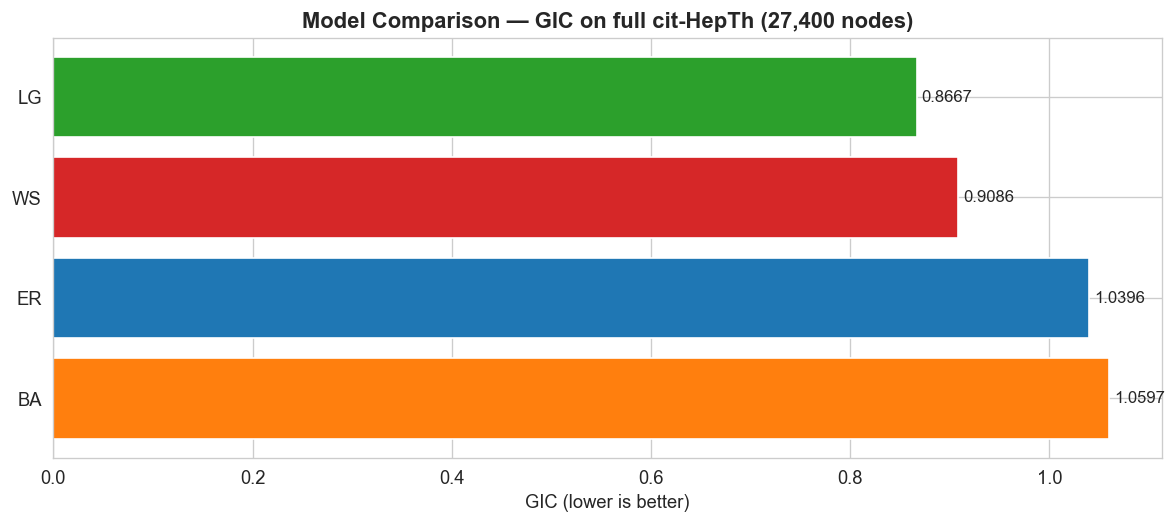

In [89]:
# GIC bar chart
colors = {'LG': '#2ca02c', 'BA': '#ff7f0e', 'ER': '#1f77b4',
          'WS': '#d62728', 'GRG': '#9467bd'}

ms_sorted = models_only.sort_values('gic')
bar_c = [colors.get(m, '#888') for m in ms_sorted['model']]

fig, ax = plt.subplots(figsize=(10, 4.5))
bars = ax.barh(ms_sorted['model'], ms_sorted['gic'],
               color=bar_c, edgecolor='white')
for bar, val in zip(bars, ms_sorted['gic']):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height() / 2,
            f'{val:.4f}', va='center', fontsize=10)
ax.set_xlabel('GIC (lower is better)')
ax.set_title(f'Model Comparison — GIC on full cit-HepTh ({n:,} nodes)',
             fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

---
## 8. Degree Distribution Comparison

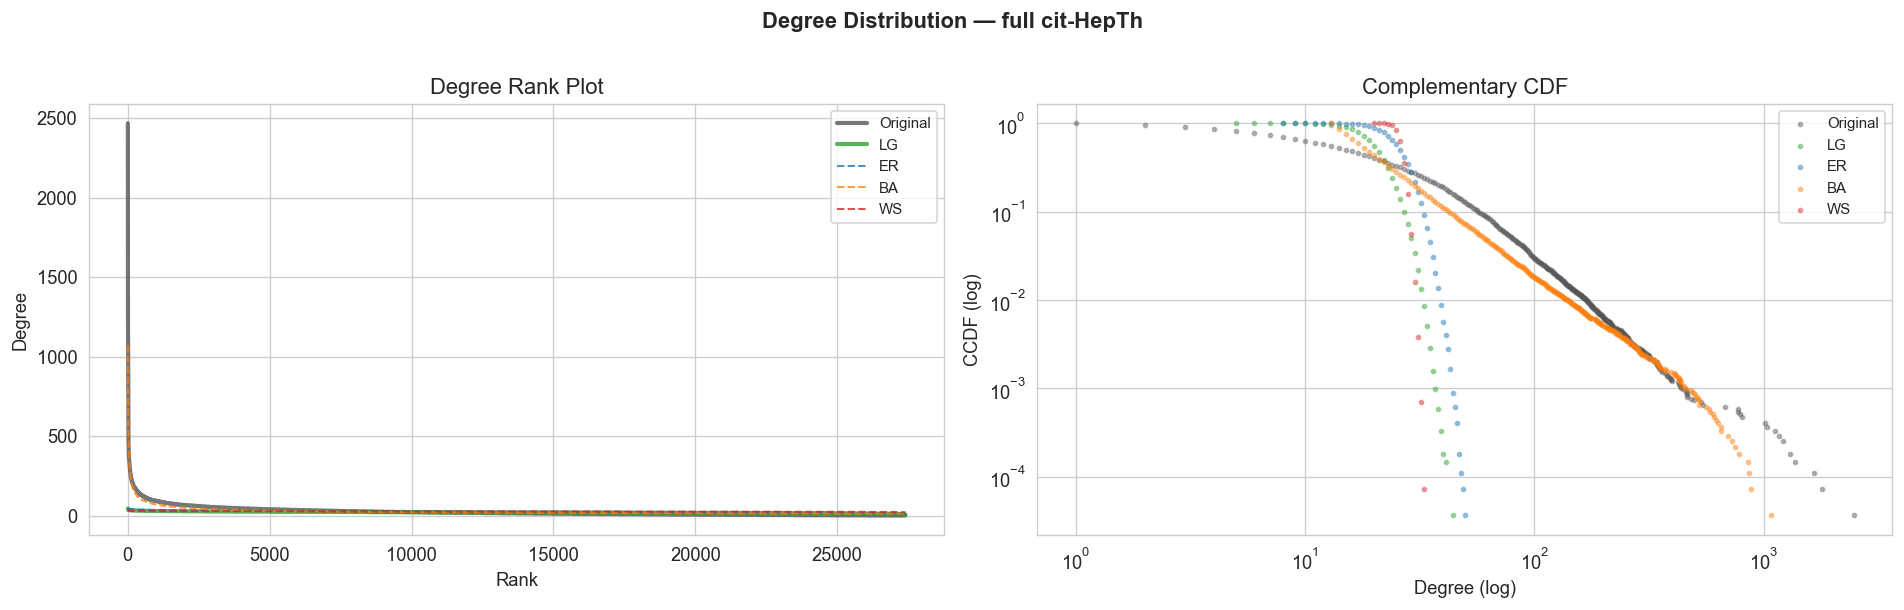

In [90]:
all_models = {'Original': G_gcc}
all_models.update({k: v['graph_nx'] for k, v in results.items()})

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for name, G_m in all_models.items():
    degs = sorted([d for _, d in G_m.degree()], reverse=True)
    color = colors.get(name, '#555')
    lw = 2.5 if name in ('Original', 'LG') else 1.2
    ls = '-' if name in ('Original', 'LG') else '--'

    axes[0].plot(np.arange(1, len(degs)+1), degs,
                 label=name, color=color, lw=lw, ls=ls, alpha=0.8)

    deg_arr = np.array(degs)
    udegs = np.unique(deg_arr)
    ccdf = np.array([np.sum(deg_arr >= d) / len(deg_arr) for d in udegs])
    axes[1].scatter(udegs, ccdf, s=6, color=color, alpha=0.4, label=name)

axes[0].set_xlabel('Rank')
axes[0].set_ylabel('Degree')
axes[0].set_title('Degree Rank Plot')
axes[0].legend(fontsize=9)

axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Degree (log)')
axes[1].set_ylabel('CCDF (log)')
axes[1].set_title('Complementary CDF')
axes[1].legend(fontsize=9)

fig.suptitle('Degree Distribution — full cit-HepTh', fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

---
## 9. Spectral Density Comparison

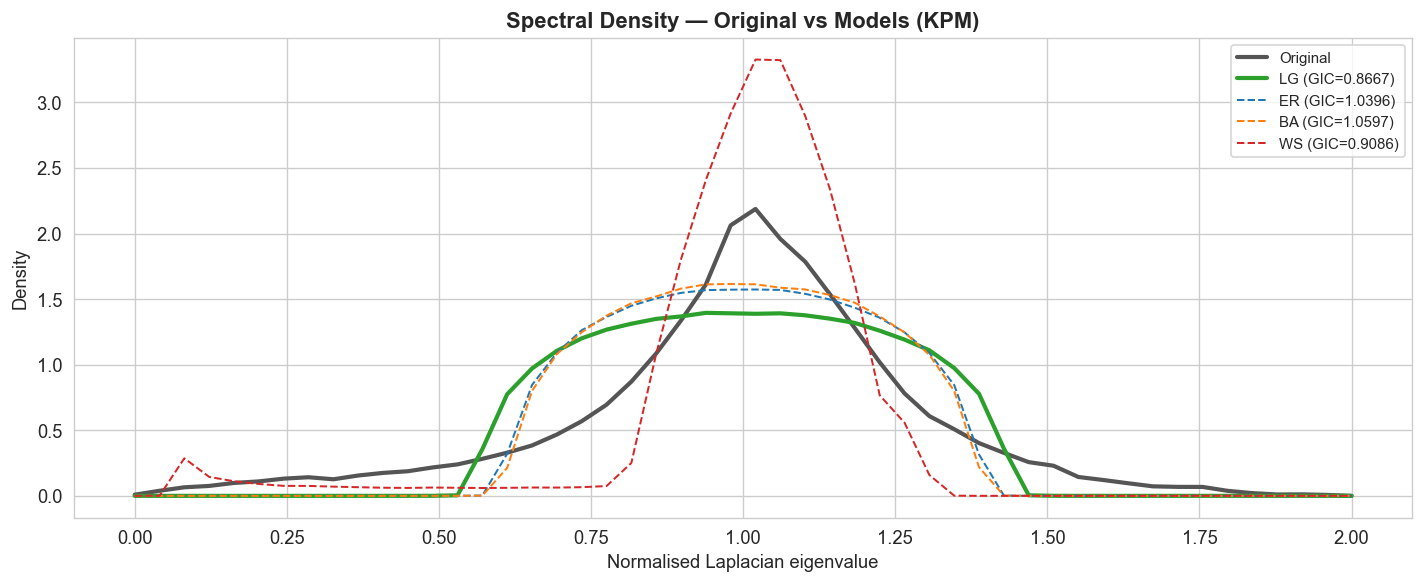

In [91]:
fig, ax = plt.subplots(figsize=(12, 5))

bins = np.linspace(0, 2, 50)
ax.plot(bins, real_density, color='#555', lw=2.5, label='Original')

for name, data in results.items():
    c = colors.get(name, '#888')
    lw = 2.5 if name == 'LG' else 1.2
    ls = '-' if name == 'LG' else '--'
    ax.plot(bins, data['density'], color=c, lw=lw, ls=ls,
            label=f"{name} (GIC={data['gic']:.4f})")

ax.set_xlabel('Normalised Laplacian eigenvalue')
ax.set_ylabel('Density')
ax.set_title('Spectral Density — Original vs Models (KPM)', fontweight='bold')
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

---
## 10. Graph Properties (cheap metrics)

In [92]:
def cheap_graph_stats(G):
    degs = np.array([d for _, d in G.degree()])
    return {
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': nx.density(G),
        'avg_degree': degs.mean(),
        'max_degree': int(degs.max()),
        'std_degree': degs.std(),
        'assortativity': nx.degree_assortativity_coefficient(G),
        'num_components': nx.number_connected_components(G),
        'triangles': sum(nx.triangles(G).values()) // 3,
    }


stat_rows = []
for name, G_m in all_models.items():
    t0 = time.perf_counter()
    stats = cheap_graph_stats(G_m)
    stats['model'] = name
    stat_rows.append(stats)
    print(f'{name:>10s}: {time.perf_counter()-t0:.1f}s')

stats_df = pd.DataFrame(stat_rows).set_index('model')
display(stats_df)

  Original: 1.0s
        LG: 1.4s
        ER: 1.1s
        BA: 1.1s
        WS: 0.8s


,nodes,edges,density,avg_degree,max_degree,std_degree,assortativity,num_components,triangles
model,,,,,,,,,
Original,27400,352021,0.000938,25.694964,2468,45.536738,-0.030457,1,1478698
LG,27400,278611,0.000742,20.336569,44,4.721268,-0.000092,1,1395
ER,27400,351176,0.000936,25.633285,50,5.077923,-0.002232,1,2766
BA,27400,356031,0.000948,25.987664,1073,32.224951,-0.010518,1,41261
WS,27400,356200,0.000949,26.000000,33,1.564525,-0.001345,1,1556839


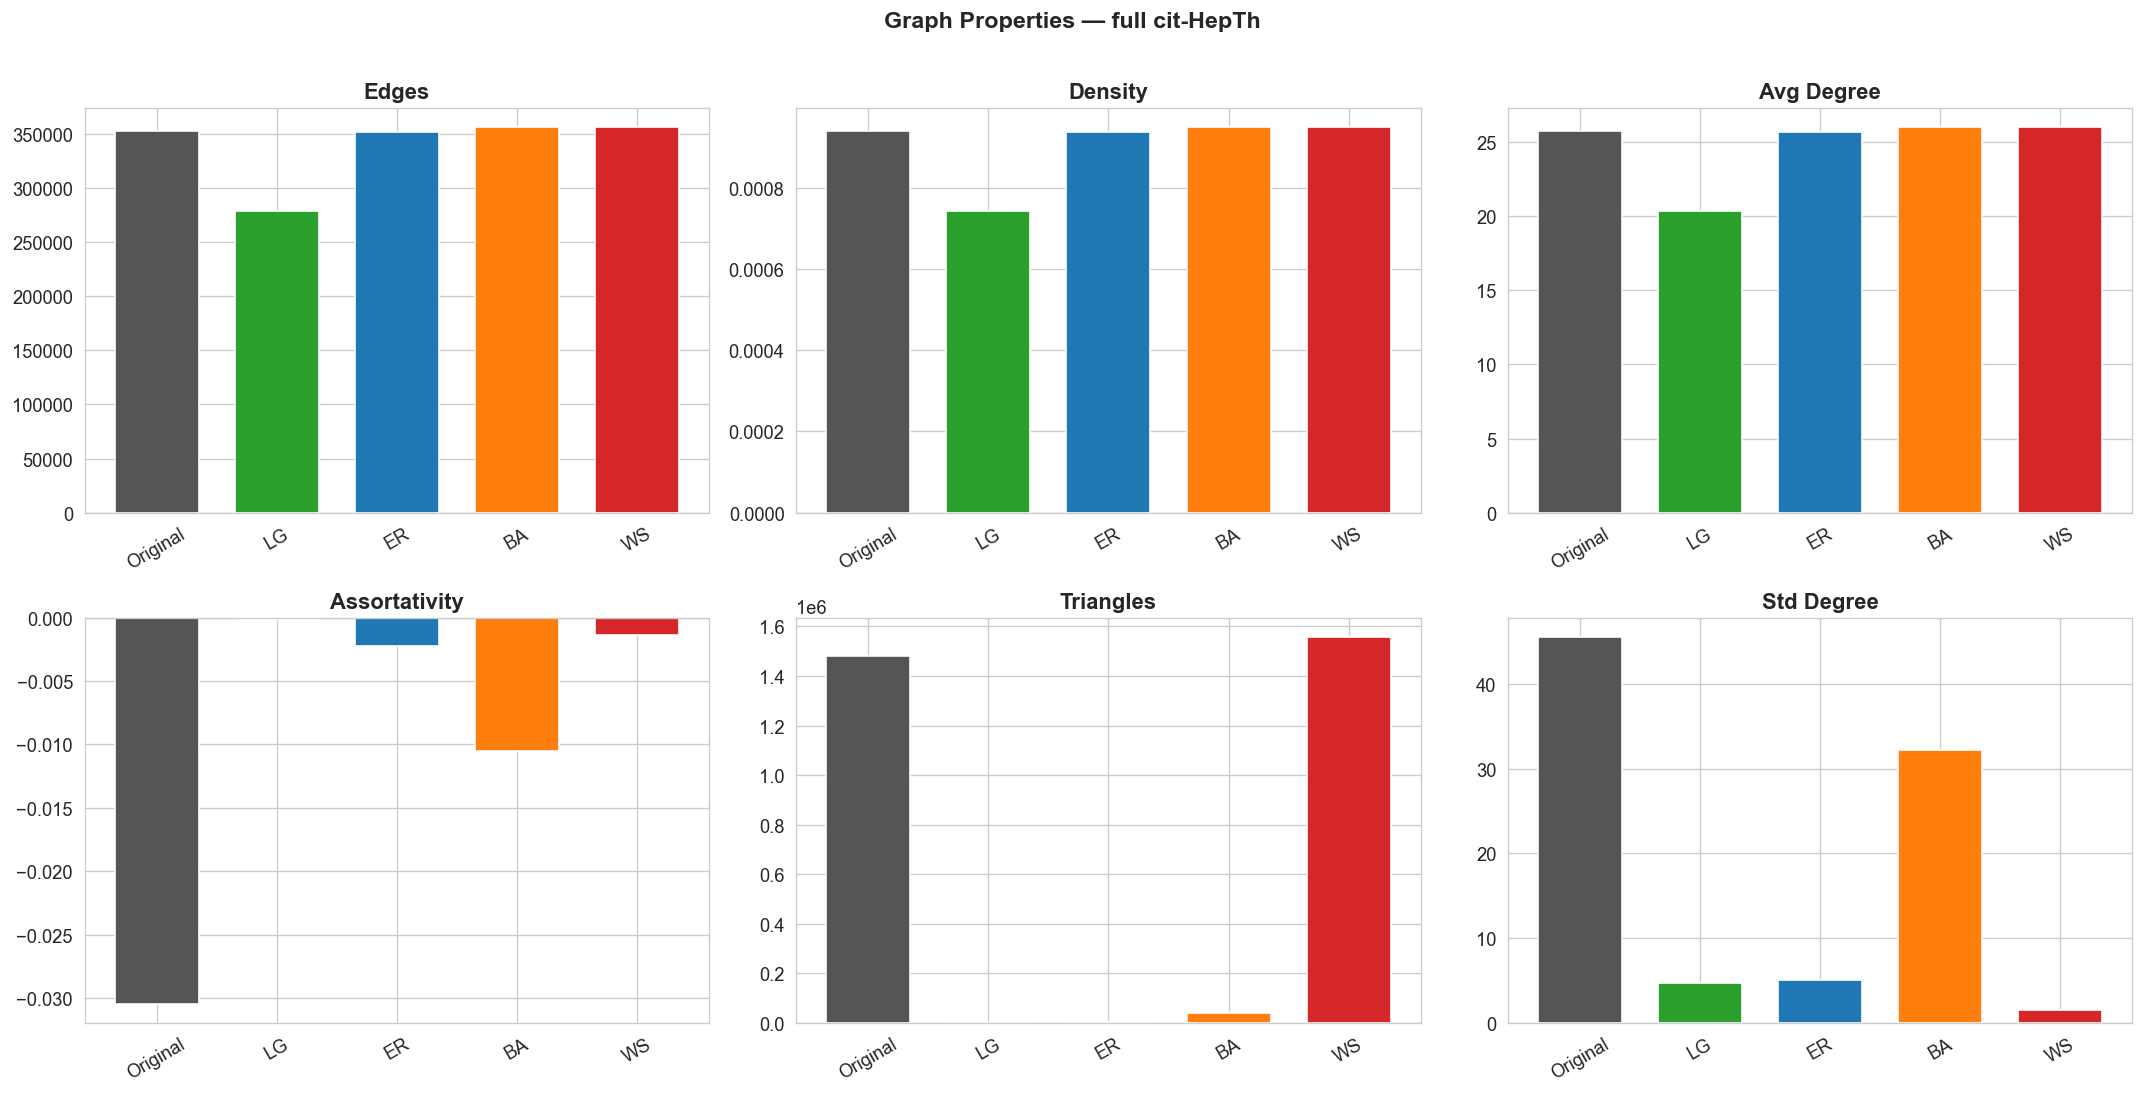

In [93]:
metrics = ['edges', 'density', 'avg_degree', 'assortativity',
           'triangles', 'std_degree']

fig, axes = plt.subplots(2, 3, figsize=(18, 9))
axes = axes.ravel()

for i, metric in enumerate(metrics):
    ax = axes[i]
    vals = stats_df[metric]
    bar_c = [colors.get(m, '#555') if m != 'Original' else '#555'
             for m in vals.index]
    vals.plot.bar(ax=ax, color=bar_c, edgecolor='white', width=0.7)
    ax.set_title(metric.replace('_', ' ').title(), fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=30)

fig.suptitle('Graph Properties — full cit-HepTh',
             fontweight='bold', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

---
## 11. Save results

In [94]:
output = {
    'summary_df': summary_df,
    'stats_df': stats_df,
    'sigma': sigma, 'beta': beta, 'd': d,
    'best_iteration': best_iter,
    'best_diff': best_diff,
    'hist_diffs': hist_diffs,
    'edge_counts': edge_counts,
    'check_iters': check_iters,
    'real_density': real_density,
}

pkl_path = os.path.join(OUTPUT_DIR, 'citation_full_results.pkl')
with open(pkl_path, 'wb') as f:
    pickle.dump(output, f)
print(f'Saved to {pkl_path}')

lg_path = os.path.join(OUTPUT_DIR, 'cit-HepTh_LG_fitted.edges')
nx.write_edgelist(results['LG']['graph_nx'], lg_path, data=False)
print(f'LG graph saved to {lg_path}')

Saved to runs/citation/citation_full_results.pkl
LG graph saved to runs/citation/cit-HepTh_LG_fitted.edges
